In [10]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16    # TODO: =====> please specify MODEL_DEPTH <=====
assert MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = 'vae_ch160v4096z32.pth', f'var_d{MODEL_DEPTH}.pth'
if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))



/Users/David/Programmiersachen/Uni/PhD-Applications/cispa-prep/code/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[init_weights] VAR with init_std=0.0180422
prepare finished.


In [31]:
from collections import defaultdict

def extract_var_activations(var_model, input_tokens, target_layers=None):
    """
    Extract activations from VAR model layers during forward pass
    
    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model
        target_layers: List of layer names to extract (if None, extracts all FFN layers)
    
    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []
    
    if target_layers is None:
        # Extract all FFN layers by default
        target_layers = []
        for name, module in var_model.named_modules():
            target_layers.append(name)
            #if not name == "head":
            #    target_layers.append(name)
            #if 'ffn.fc1' in name or 'ffn.fc2' in name or name == 'head':
            #    target_layers.append(name)
    
    def make_hook(layer_name):
        def hook_fn(module, input, output):
            # Store activation, handling different output shapes
            if isinstance(output, torch.Tensor):
                if len(output.shape) == 3:  # [batch, sequence, features]
                    # Average across sequence dimension for transformers
                    activations[layer_name] = output.mean(dim=1).detach()
                else:
                    activations[layer_name] = output.detach()
            else:
                # Handle tuple outputs (some layers return multiple values)
                activations[layer_name] = output[0].detach()
        return hook_fn
    
    # Register hooks
    for layer_name in target_layers:
        try:
            layer = dict(var_model.named_modules())[layer_name]
            hook = layer.register_forward_hook(make_hook(layer_name))
            hooks.append(hook)
        except KeyError:
            print(f"Warning: Layer {layer_name} not found")
    
    # Perform forward pass
    try:
        with torch.no_grad():
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()
    
    return activations


def extract_all_linear_activations(var_model, input_tokens):
    """
    Extract activations from all Linear (fully connected) layers in the VAR model.

    Args:
        var_model: The loaded VAR model
        input_tokens: Input tokens for the model

    Returns:
        Dictionary of layer_name -> activation tensor
    """
    activations = {}
    hooks = []

    # Find all Linear layers
    for name, module in var_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            def make_hook(layer_name):
                def hook_fn(module, input, output):
                    if isinstance(output, torch.Tensor):
                        if len(output.shape) == 3:
                            activations[layer_name] = output.mean(dim=1).detach()
                        else:
                            activations[layer_name] = output.detach()
                    else:
                        activations[layer_name] = output[0].detach()
                return hook_fn
            hook = module.register_forward_hook(make_hook(name))
            hooks.append(hook)

    try:
        with torch.no_grad():
            _ = var_model(torch.tensor([1,]), input_tokens)
    finally:
        for hook in hooks:
            hook.remove()

    return activations

In [12]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
# Create dataset
dataset = datasets.ImageFolder(
    root='./data/train.X1/',
    transform=transform
)
# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1
)

In [13]:
import torchvision.transforms as transforms
import torchvision
s = 1
color_jitter = transforms.ColorJitter(
        0.9 * s, 0.9 * s, 0.9 * s, 0.1 * s)
flip = transforms.RandomHorizontalFlip()
Aug = transforms.Compose(
    [
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([color_jitter], p=0.9),
    transforms.RandomGrayscale(p=0.1)
    ])

0
torch.Size([1, 3, 256, 256])


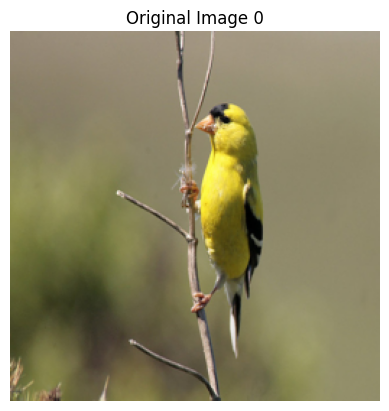

/Users/David/Programmiersachen/Uni/PhD-Applications/cispa-prep/code/VAR/models/var.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


1
torch.Size([1, 3, 256, 256])


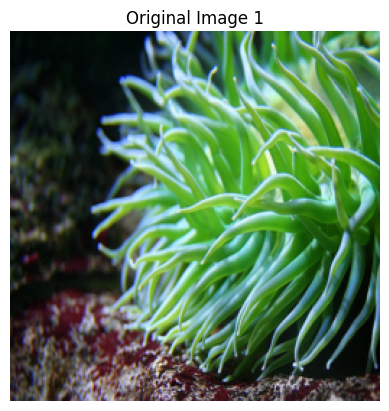

2
torch.Size([1, 3, 256, 256])


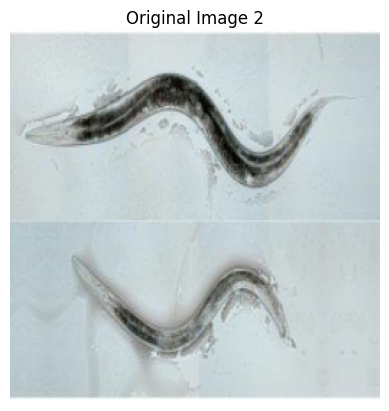

3
torch.Size([1, 3, 256, 256])


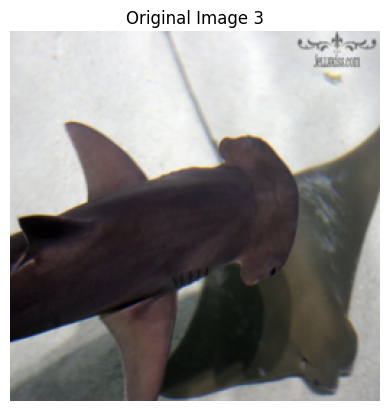

4
torch.Size([1, 3, 256, 256])


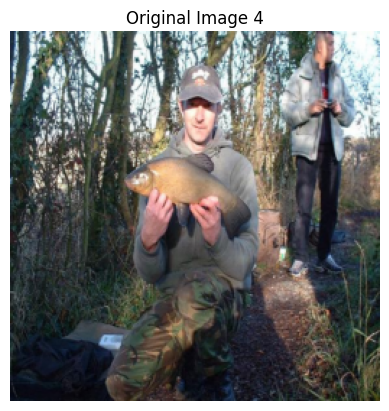

5
torch.Size([1, 3, 256, 256])


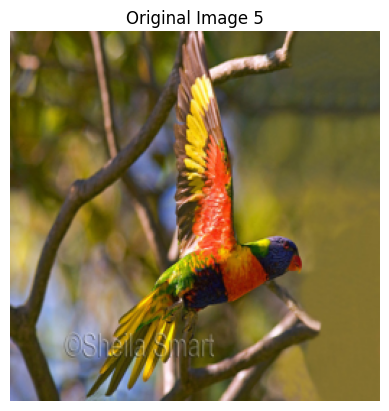

6
torch.Size([1, 3, 256, 256])


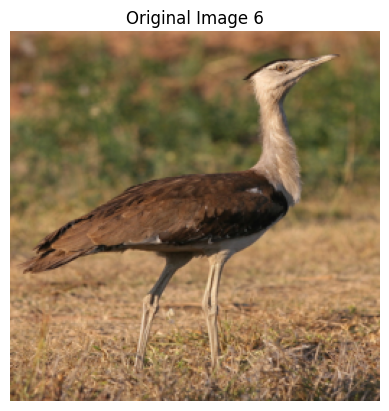

7
torch.Size([1, 3, 256, 256])


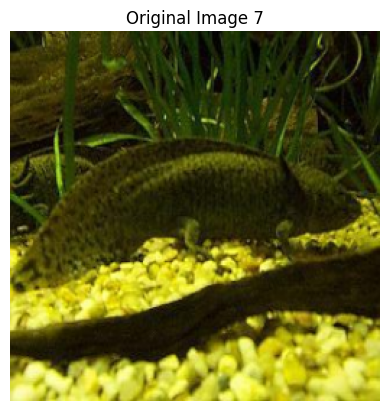

8
torch.Size([1, 3, 256, 256])


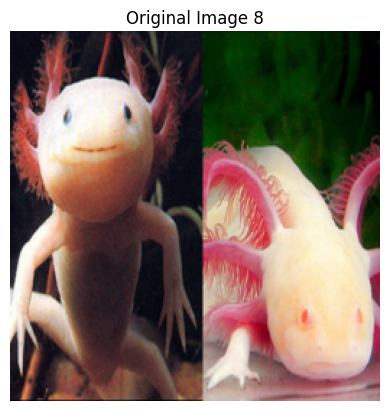

9
torch.Size([1, 3, 256, 256])


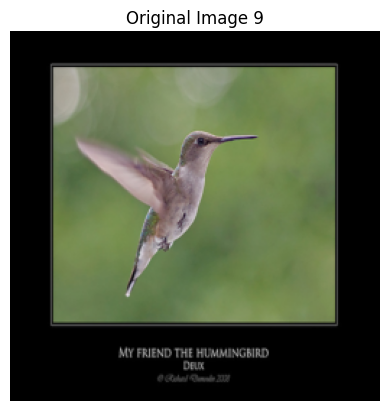

10
torch.Size([1, 3, 256, 256])


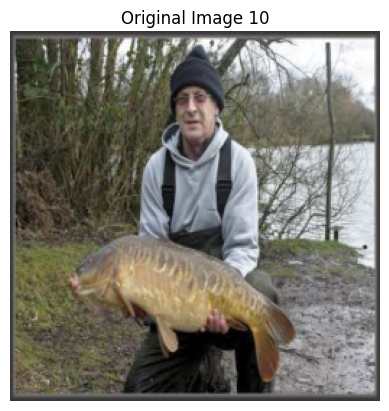

11
torch.Size([1, 3, 256, 256])


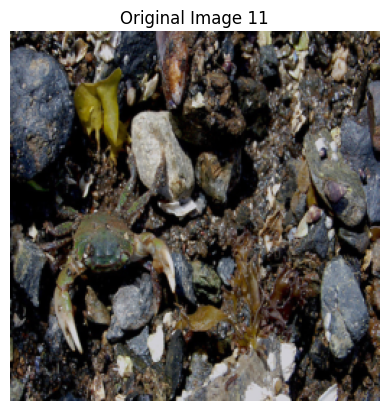

12
torch.Size([1, 3, 256, 256])


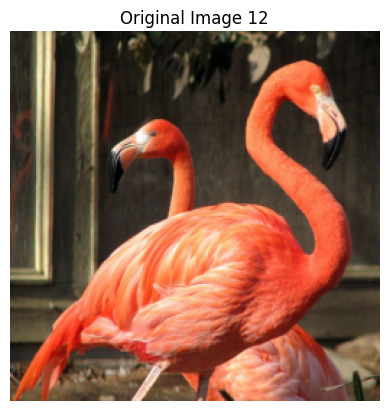

13
torch.Size([1, 3, 256, 256])


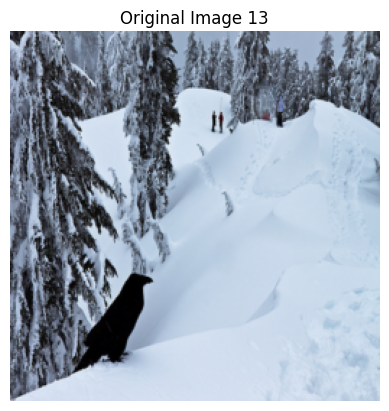

14
torch.Size([1, 3, 256, 256])


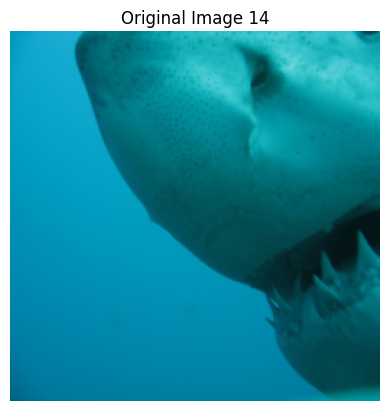

15
torch.Size([1, 3, 256, 256])


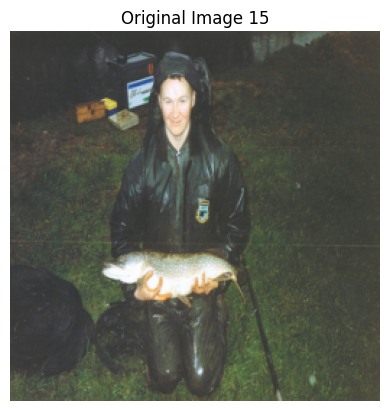

16
torch.Size([1, 3, 256, 256])


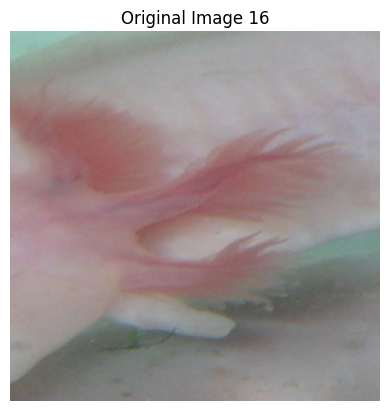

17
torch.Size([1, 3, 256, 256])


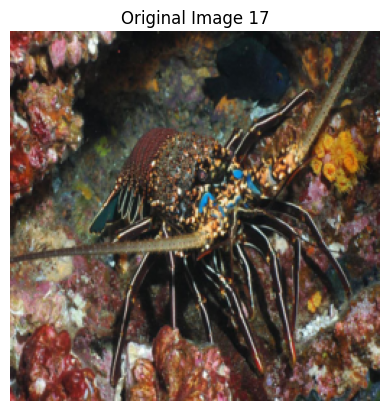

18
torch.Size([1, 3, 256, 256])


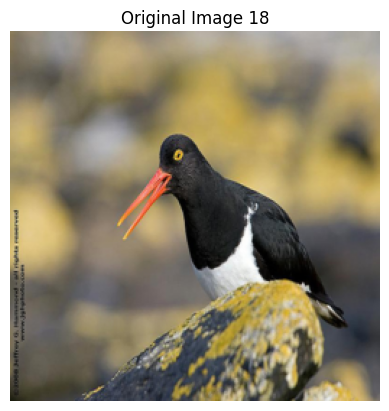

19
torch.Size([1, 3, 256, 256])


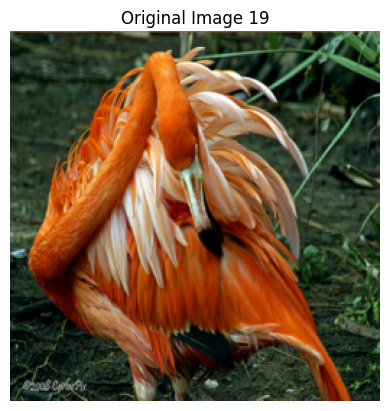

20


In [32]:
nsamples = 20
all_means = []
for i, image in enumerate(dataloader): 
    print(i)
    if i >= nsamples:
        break
    image = image[0]
    print(image.shape)
    # Display the image before augmentation
    import matplotlib.pyplot as plt
    img_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img_np)
    plt.title(f"Original Image {i}")
    plt.axis('off')
    plt.show()

    image = image.to(device)
    this_imgs_activations = []
    for _ in range(10):  # Iterate over different random augmentations
        image = Aug(image)  # Apply random augmentation
        with torch.no_grad():
            vae_out = vae.img_to_idxBl(image)
            var_in = var.vae_quant_proxy[0].idxBl_to_var_input(vae_out)    
        activations = extract_var_activations(var, var_in)
        this_imgs_activations.append(activations)
    # Compute the mean activation across all augmentations for each layer in all_activations
    layer_means = {}
    if this_imgs_activations:
        # Get all layer names from the first activation dict
        layer_names = this_imgs_activations[0].keys()
        for lname in layer_names:
            # Stack tensors for this layer across all augmentations
            stacked = torch.stack([a[lname] for a in this_imgs_activations], dim=0)
            # Compute mean across augmentations (dim=0)
            layer_means[lname] = stacked.mean(dim=0)
    all_means.append(layer_means)

In [33]:
#For each layer, stack all mean activations across images and compute the maximum and argmax per unit
max_per_unit_all_layers = {}
argmax_per_unit_all_layers = {}

if all_means:
    layer_names = all_means[0].keys()
    for lname in layer_names:
        # Stack all mean activations for this layer across images
        stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
        # Compute the maximum and argmax for each unit across all images (dim=0)
        stacked_means = stacked_means.abs()
        max_per_unit_all_layers[lname] = stacked_means.max(dim=0).values
        argmax_per_unit_all_layers[lname] = stacked_means.argmax(dim=0)
        print(f"Layer: {lname}")
        print(f"Maximum per unit: {max_per_unit_all_layers[lname]}")
        print(f"Argmax per unit: {argmax_per_unit_all_layers[lname]}")

Layer: class_emb
Maximum per unit: tensor([[0.0441, 0.0110, 0.1207,  ..., 0.0135, 0.0092, 0.0585]])
Argmax per unit: tensor([[3, 3, 3,  ..., 3, 7, 3]])
Layer: word_embed
Maximum per unit: tensor([[0.0301, 0.0150, 0.0425,  ..., 0.1210, 0.0064, 0.0305]])
Argmax per unit: tensor([[14, 19,  1,  ...,  0,  0,  9]])
Layer: lvl_embed
Maximum per unit: tensor([[0.0157, 0.0072, 0.0319,  ..., 0.0143, 0.0051, 0.0010]])
Argmax per unit: tensor([[0, 0, 0,  ..., 0, 0, 0]])
Layer: shared_ada_lin
Maximum per unit: tensor([[0.0441, 0.0110, 0.1207,  ..., 0.0135, 0.0092, 0.0585]])
Argmax per unit: tensor([[3, 3, 3,  ..., 3, 7, 3]])
Layer: blocks.0.ada_lin.0
Maximum per unit: tensor([[0.0225, 0.0055, 0.0640,  ..., 0.0068, 0.0047, 0.0301]])
Argmax per unit: tensor([[3, 3, 3,  ..., 3, 7, 3]])
Layer: blocks.0.ada_lin.1
Maximum per unit: tensor([[0.0460, 0.0314, 0.3568,  ..., 0.0579, 0.0207, 0.2597]])
Argmax per unit: tensor([[3, 3, 7,  ..., 7, 7, 7]])
Layer: blocks.0.ada_lin
Maximum per unit: tensor([[0.0460,

In [34]:
import pandas as pd

# Flatten all argmax values from all layers into a single tensor
all_argmax = []
for v in argmax_per_unit_all_layers.values():
    all_argmax.append(v.flatten())
all_argmax = torch.cat(all_argmax)

# Count occurrences of each argmax value
values, counts = torch.unique(all_argmax, return_counts=True)
argmax_freq_df = pd.DataFrame({'Argmax Value': values.cpu().numpy(), 'Count': counts.cpu().numpy()})
argmax_freq_df = argmax_freq_df.sort_values('Count', ascending=False).reset_index(drop=True)

display(argmax_freq_df)


Argmax Value   Count
0              7  121472
1              3  107763
2             14   87402
3              9   30097
4              1   25151
5              4   19845
6             15   18544
7             13   17166
8             12   11835
9              6   10945
10             8    9301
11            16    8995
12            11    8773
13             0    8432
14             5    8130
15             2    7129
16            10    3383
17            18    2667
18            19    2583
19            17    1363

In [45]:
import pandas as pd

# Get the argmax values for the top 100 units with highest max activation
top100_argmax = []
for lname, unit_idx in top100_units:
    argmax_tensor = argmax_per_unit_all_layers[lname]
    top100_argmax.append(argmax_tensor[0, unit_idx].item())

# Count occurrences of each argmax value
values, counts = np.unique(top100_argmax, return_counts=True)
top100_argmax_freq_df = pd.DataFrame({'Argmax Value': values, 'Count': counts})
top100_argmax_freq_df = top100_argmax_freq_df.sort_values('Count', ascending=False).reset_index(drop=True)

display(top100_argmax_freq_df)


Argmax Value  Count
0             14     67
1              4      8
2             15      7
3             13      6
4              1      5
5              2      1
6              6      1
7              7      1
8             11      1
9             12      1
10            17      1
11            18      1

In [35]:
# For each layer, compute the mean activation across all images except the one at argmax for each unit
mean_minus_max_per_unit_all_layers = {}

if all_means:
    layer_names = all_means[0].keys()
    n_imgs = len(all_means)
    for lname in layer_names:
        # Stack all mean activations for this layer across images: shape [n_imgs, 1, n_units]
        stacked_means = torch.stack([mean[lname] for mean in all_means], dim=0)
        # Find argmax index for each unit
        stacked_means = stacked_means.abs()
        argmax_idx = stacked_means.argmax(dim=0)  # shape [1, n_units]
        # For each unit, exclude the image at argmax and compute mean over the rest
        means = []
        for unit in range(stacked_means.shape[2]):
            # Get indices of all images except the one at argmax for this unit
            mask = torch.ones(n_imgs, dtype=torch.bool)
            mask[argmax_idx[0, unit]] = False
            # Compute mean over the remaining images for this unit
            mean_val = stacked_means[mask, 0, unit].mean()
            means.append(mean_val)
        mean_minus_max_per_unit_all_layers[lname] = torch.stack(means)
        print(f"Layer: {lname}, µ-max per unit shape: {mean_minus_max_per_unit_all_layers[lname]}")

Layer: class_emb, µ-max per unit shape: tensor([0.0347, 0.0064, 0.1096,  ..., 0.0086, 0.0031, 0.0553])
Layer: word_embed, µ-max per unit shape: tensor([0.0222, 0.0114, 0.0123,  ..., 0.0851, 0.0019, 0.0271])
Layer: lvl_embed, µ-max per unit shape: tensor([0.0157, 0.0072, 0.0319,  ..., 0.0143, 0.0051, 0.0010])
Layer: shared_ada_lin, µ-max per unit shape: tensor([0.0347, 0.0064, 0.1096,  ..., 0.0086, 0.0031, 0.0553])
Layer: blocks.0.ada_lin.0, µ-max per unit shape: tensor([0.0178, 0.0032, 0.0580,  ..., 0.0043, 0.0016, 0.0284])
Layer: blocks.0.ada_lin.1, µ-max per unit shape: tensor([0.0414, 0.0294, 0.3543,  ..., 0.0456, 0.0191, 0.2580])
Layer: blocks.0.ada_lin, µ-max per unit shape: tensor([0.0414, 0.0294, 0.3543,  ..., 0.0456, 0.0191, 0.2580])
Layer: blocks.0.ln_wo_grad, µ-max per unit shape: tensor([0.1333, 0.0220, 0.1249,  ..., 0.0426, 0.0097, 0.1916])
Layer: blocks.0.attn.proj, µ-max per unit shape: tensor([0.1064, 0.2076, 0.1460,  ..., 0.2925, 0.1669, 0.0478])
Layer: blocks.0.attn.pr

In [36]:
# Compute the difference between max_per_unit_all_layers and mean_minus_max_per_unit_all_layers for each layer
diff_max_minus_mean_all_layers = {}

for lname in max_per_unit_all_layers.keys():
    diff_max_minus_mean_all_layers[lname] = max_per_unit_all_layers[lname] - mean_minus_max_per_unit_all_layers[lname]
    print(f"Layer: {lname}, Difference shape: {diff_max_minus_mean_all_layers[lname].shape}")
    print(diff_max_minus_mean_all_layers[lname])

Layer: class_emb, Difference shape: torch.Size([1, 1024])
tensor([[0.0094, 0.0046, 0.0111,  ..., 0.0049, 0.0061, 0.0031]])
Layer: word_embed, Difference shape: torch.Size([1, 1024])
tensor([[0.0079, 0.0035, 0.0302,  ..., 0.0359, 0.0045, 0.0034]])
Layer: lvl_embed, Difference shape: torch.Size([1, 1024])
tensor([[ 0.0000e+00,  4.6566e-10,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -5.8208e-11]])
Layer: shared_ada_lin, Difference shape: torch.Size([1, 1024])
tensor([[0.0094, 0.0046, 0.0111,  ..., 0.0049, 0.0061, 0.0031]])
Layer: blocks.0.ada_lin.0, Difference shape: torch.Size([1, 1024])
tensor([[0.0047, 0.0023, 0.0060,  ..., 0.0024, 0.0031, 0.0016]])
Layer: blocks.0.ada_lin.1, Difference shape: torch.Size([1, 6144])
tensor([[0.0046, 0.0020, 0.0026,  ..., 0.0123, 0.0016, 0.0017]])
Layer: blocks.0.ada_lin, Difference shape: torch.Size([1, 6144])
tensor([[0.0046, 0.0020, 0.0026,  ..., 0.0123, 0.0016, 0.0017]])
Layer: blocks.0.ln_wo_grad, Difference shape: torch.Size([1, 1024])
t

In [37]:
# Compute the normalized difference: (max - mean) / (max + mean) for each layer
normalized_diff_all_layers = {}

for lname in diff_max_minus_mean_all_layers.keys():
    max_vals = max_per_unit_all_layers[lname]
    mean_vals = mean_minus_max_per_unit_all_layers[lname]
    denom = max_vals + mean_vals
    # Avoid division by zero
    normalized_diff = diff_max_minus_mean_all_layers[lname] / (denom + 1e-8)
    normalized_diff_all_layers[lname] = normalized_diff
    print(f"Layer: {lname}, Normalized difference shape: {normalized_diff.shape}")
    print(normalized_diff)

Layer: class_emb, Normalized difference shape: torch.Size([1, 1024])
tensor([[0.1188, 0.2669, 0.0482,  ..., 0.2225, 0.4974, 0.0276]])
Layer: word_embed, Normalized difference shape: torch.Size([1, 1024])
tensor([[0.1508, 0.1342, 0.5500,  ..., 0.1742, 0.5499, 0.0595]])
Layer: lvl_embed, Normalized difference shape: torch.Size([1, 1024])
tensor([[ 0.0000e+00,  3.2241e-08,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -3.0130e-08]])
Layer: shared_ada_lin, Normalized difference shape: torch.Size([1, 1024])
tensor([[0.1188, 0.2669, 0.0482,  ..., 0.2225, 0.4974, 0.0276]])
Layer: blocks.0.ada_lin.0, Normalized difference shape: torch.Size([1, 1024])
tensor([[0.1166, 0.2634, 0.0489,  ..., 0.2188, 0.4971, 0.0280]])
Layer: blocks.0.ada_lin.1, Normalized difference shape: torch.Size([1, 6144])
tensor([[0.0526, 0.0334, 0.0036,  ..., 0.1187, 0.0398, 0.0032]])
Layer: blocks.0.ada_lin, Normalized difference shape: torch.Size([1, 6144])
tensor([[0.0526, 0.0334, 0.0036,  ..., 0.1187, 0.0398, 0.

In [38]:
# Flatten all normalized differences across all layers into a single tensor
all_norm_diffs = []
unit_layer_map = []

for lname, norm_diff in normalized_diff_all_layers.items():
    # norm_diff shape: [1, n_units]
    n_units = norm_diff.shape[1]
    for unit_idx in range(n_units):
        all_norm_diffs.append(norm_diff[0, unit_idx].item())
        unit_layer_map.append((lname, unit_idx))

all_norm_diffs = torch.tensor(all_norm_diffs)

# Compute the number of top units (10%)
topk_percent = 0.1
k = max(1, int(len(all_norm_diffs) * topk_percent))

# Get the indices of the top 10% highest values
topk_vals, topk_indices = torch.topk(all_norm_diffs, k)

# Map indices back to (layer, unit) pairs
topk_units_overall = [unit_layer_map[idx] for idx in topk_indices.tolist()]

print(f"Top {k} units overall (layer, unit): {topk_units_overall}")

Top 51097 units overall (layer, unit): [('blocks.1.ffn.act', 3682), ('blocks.1.ffn.act', 1282), ('blocks.1.ffn.act', 1256), ('blocks.1.ffn.act', 431), ('blocks.1.ffn.act', 3763), ('blocks.0.ffn.act', 3350), ('blocks.0.ffn.act', 3179), ('blocks.5.ffn.act', 3883), ('blocks.1.ffn.act', 3488), ('blocks.1.ffn.act', 2140), ('blocks.0.ffn.act', 1519), ('blocks.1.ffn.act', 2541), ('blocks.15.ffn', 519), ('blocks.15.ffn.fc2', 519), ('blocks.15.ffn.drop', 519), ('blocks.1.ffn.act', 1683), ('blocks.15.drop_path', 519), ('blocks.0.ffn.act', 2395), ('blocks.15', 519), ('blocks.0.ffn.act', 3871), ('blocks.2.ffn.act', 2700), ('blocks.0.drop_path', 807), ('head_nm.ln_wo_grad', 519), ('head_nm', 519), ('blocks.15.ffn.act', 2010), ('blocks.5.ffn.act', 2011), ('blocks.0.ffn.act', 489), ('blocks.0.ffn.act', 3549), ('blocks.4.ffn.act', 1721), ('blocks.0.ffn.act', 3284), ('blocks.1.ffn.act', 688), ('blocks.1.ffn.act', 972), ('blocks.0.ffn.act', 3003), ('blocks.1.ffn.act', 1541), ('blocks.0.ffn.act', 3304), 

In [39]:
# Choose the 10% highest activating units overall (across all layers)
all_units = []
unit_layer_map = []

for lname, norm_diff in normalized_diff_all_layers.items():
    # norm_diff shape: [1, n_units]
    n_units = norm_diff.shape[1]
    for unit_idx in range(n_units):
        all_units.append(norm_diff[0, unit_idx].item())
        unit_layer_map.append((lname, unit_idx))

all_units = torch.tensor(all_units)
k = max(1, int(len(all_units) * topk_percent))
topk_vals, topk_indices = torch.topk(all_units, k)

# Map back to (layer, unit) pairs
# Exclude units from the 'head' layer
topk_units_overall = [unit_layer_map[idx] for idx in topk_indices.tolist() if unit_layer_map[idx][0] != 'head']
print(f"Top {k} units overall (layer, unit) excluding 'head': {topk_units_overall}")

Top 51097 units overall (layer, unit) excluding 'head': [('blocks.1.ffn.act', 3682), ('blocks.1.ffn.act', 1282), ('blocks.1.ffn.act', 1256), ('blocks.1.ffn.act', 431), ('blocks.1.ffn.act', 3763), ('blocks.0.ffn.act', 3350), ('blocks.0.ffn.act', 3179), ('blocks.5.ffn.act', 3883), ('blocks.1.ffn.act', 3488), ('blocks.1.ffn.act', 2140), ('blocks.0.ffn.act', 1519), ('blocks.1.ffn.act', 2541), ('blocks.15.ffn', 519), ('blocks.15.ffn.fc2', 519), ('blocks.15.ffn.drop', 519), ('blocks.1.ffn.act', 1683), ('blocks.15.drop_path', 519), ('blocks.0.ffn.act', 2395), ('blocks.15', 519), ('blocks.0.ffn.act', 3871), ('blocks.2.ffn.act', 2700), ('blocks.0.drop_path', 807), ('head_nm.ln_wo_grad', 519), ('head_nm', 519), ('blocks.15.ffn.act', 2010), ('blocks.5.ffn.act', 2011), ('blocks.0.ffn.act', 489), ('blocks.0.ffn.act', 3549), ('blocks.4.ffn.act', 1721), ('blocks.0.ffn.act', 3284), ('blocks.1.ffn.act', 688), ('blocks.1.ffn.act', 972), ('blocks.0.ffn.act', 3003), ('blocks.1.ffn.act', 1541), ('blocks.0.

In [40]:
import pandas as pd

# Create a DataFrame showing the distribution of top-k units across layers, ordered by layer position

# Extract just the layer names from topk_units_overall (ignore unit index)
topk_layer_names = [layer for layer, unit in topk_units_overall]

# Count occurrences of each layer in the top-k units
layer_counts = pd.Series(topk_layer_names).value_counts().rename_axis('Layer').reset_index(name='TopK_Count')

# To order by layer position, extract the numeric index from the layer name (e.g., 'blocks.3.ffn.fc1' -> 3)
def layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        # Extract the block number
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = -1
        # Optionally, sort by sublayer type as well
        sublayer_priority = {'ffn.fc1': 0, 'ffn.fc2': 1, 'attn.proj': 2, 'ada_lin.1': 3}
        sublayer = '.'.join(parts[2:]) if len(parts) > 2 else ''
        sublayer_idx = sublayer_priority.get(sublayer, 99)
        return (block_num, sublayer_idx)
    elif layer_name == 'word_embed':
        return (-2, 0)
    elif layer_name == 'head':
        return (999, 0)
    else:
        return (998, 0)

layer_counts['sort_key'] = layer_counts['Layer'].apply(layer_sort_key)
layer_counts = layer_counts.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

# Show the full DataFrame without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
    display(layer_counts)


Layer  TopK_Count
0                  word_embed         130
1            blocks.0.ffn.fc1         163
2            blocks.0.ffn.fc2         219
3          blocks.0.attn.proj         180
4          blocks.0.ada_lin.1          19
5            blocks.0.ffn.act         421
6           blocks.0.ffn.drop         219
7         blocks.0.ln_wo_grad          99
8                    blocks.0         123
9            blocks.0.ada_lin          19
10               blocks.0.ffn         219
11    blocks.0.attn.proj_drop         180
12         blocks.0.drop_path         235
13              blocks.0.attn         180
14         blocks.0.ada_lin.0          19
15           blocks.1.ffn.fc1         294
16           blocks.1.ffn.fc2         274
17         blocks.1.attn.proj         226
18         blocks.1.ada_lin.1          21
19    blocks.1.attn.proj_drop         226
20         blocks.1.drop_path         281
21                   blocks.1         162
22           blocks.1.ada_lin          21
23         blocks.1.ada_lin.0          19
24          blocks.1.ffn.drop         274
25              blocks.1.attn         226
26        blocks.1.ln_wo_grad         130
27           blocks.1.ffn.act         796
28               blocks.1.ffn         274
29           blocks.2.ffn.fc1         144
30           blocks.2.ffn.fc2         355
31         blocks.2.attn.proj         239
32         blocks.2.ada_lin.1          18
33                   blocks.2         188
34    blocks.2.attn.proj_drop         239
35              blocks.2.attn         239
36        blocks.2.ln_wo_grad         190
37               blocks.2.ffn         355
38         blocks.2.ada_lin.0          19
39           blocks.2.ada_lin          18
40          blocks.2.ffn.drop         355
41           blocks.2.ffn.act         595
42         blocks.2.drop_path         361
43           blocks.3.ffn.fc1         129
44           blocks.3.ffn.fc2         291
45         blocks.3.attn.proj         224
46         blocks.3.ada_lin.1          12
47           blocks.3.ffn.act         473
48    blocks.3.attn.proj_drop         224
49        blocks.3.ln_wo_grad         207
50           blocks.3.ada_lin          12
51                   blocks.3         211
52          blocks.3.ffn.drop         291
53               blocks.3.ffn         291
54         blocks.3.ada_lin.0          19
55         blocks.3.drop_path         288
56              blocks.3.attn         224
57           blocks.4.ffn.fc1         143
58           blocks.4.ffn.fc2         238
59         blocks.4.attn.proj         197
60         blocks.4.ada_lin.1          21
61    blocks.4.attn.proj_drop         197
62                   blocks.4         214
63              blocks.4.attn         197
64           blocks.4.ada_lin          21
65          blocks.4.ffn.drop         238
66         blocks.4.drop_path         240
67        blocks.4.ln_wo_grad         203
68           blocks.4.ffn.act         329
69         blocks.4.ada_lin.0          19
70               blocks.4.ffn         238
71           blocks.5.ffn.fc1         147
72           blocks.5.ffn.fc2         248
73         blocks.5.attn.proj         204
74         blocks.5.ada_lin.1          22
75              blocks.5.attn         204
76    blocks.5.attn.proj_drop         204
77           blocks.5.ffn.act         289
78         blocks.5.drop_path         248
79        blocks.5.ln_wo_grad         225
80                   blocks.5         218
81               blocks.5.ffn         248
82           blocks.5.ada_lin          22
83         blocks.5.ada_lin.0          19
84          blocks.5.ffn.drop         248
85           blocks.6.ffn.fc1          95
86           blocks.6.ffn.fc2         240
87         blocks.6.attn.proj         202
88         blocks.6.ada_lin.1          31
89           blocks.6.ada_lin          31
90              blocks.6.attn         202
91           blocks.6.ffn.act         190
92                   blocks.6         218
93        blocks.6.ln_wo_grad         229
94          blocks.6.ffn.drop     

In [41]:
import pandas as pd

# Extract block names from topk_layer_names (e.g., 'blocks.3.ffn.act' -> 'blocks.3')
def extract_block_name(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        return f"{parts[0]}.{parts[1]}"
    else:
        return layer_name  # For non-block layers like 'word_embed', etc.

topk_block_names = [extract_block_name(name) for name in topk_layer_names]

# Count occurrences of each block in the top-k units
block_counts = pd.Series(topk_block_names).value_counts().rename_axis('Block').reset_index(name='TopK_Count')

# Sort blocks numerically if possible
def block_sort_key(block_name):
    if block_name.startswith('blocks.'):
        try:
            return int(block_name.split('.')[1])
        except Exception:
            return 999
    else:
        return 1000  # Non-blocks at the end

block_counts['sort_key'] = block_counts['Block'].apply(block_sort_key)
block_counts = block_counts.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

display(block_counts)

Block  TopK_Count
0             blocks.0        2295
1             blocks.1        3224
2             blocks.2        3315
3             blocks.3        2896
4             blocks.4        2495
5             blocks.5        2546
6             blocks.6        2374
7             blocks.7        2511
8             blocks.8        2236
9             blocks.9        1981
10           blocks.10        2069
11           blocks.11        1733
12           blocks.12        1513
13           blocks.13        1739
14           blocks.14        2817
15           blocks.15        8019
16                            3083
17             head_nm         541
18  head_nm.ln_wo_grad         430
19          word_embed         130
20   head_nm.ada_lin.0          19
21      shared_ada_lin          19
22           class_emb          19
23     head_nm.ada_lin           5
24   head_nm.ada_lin.1           5

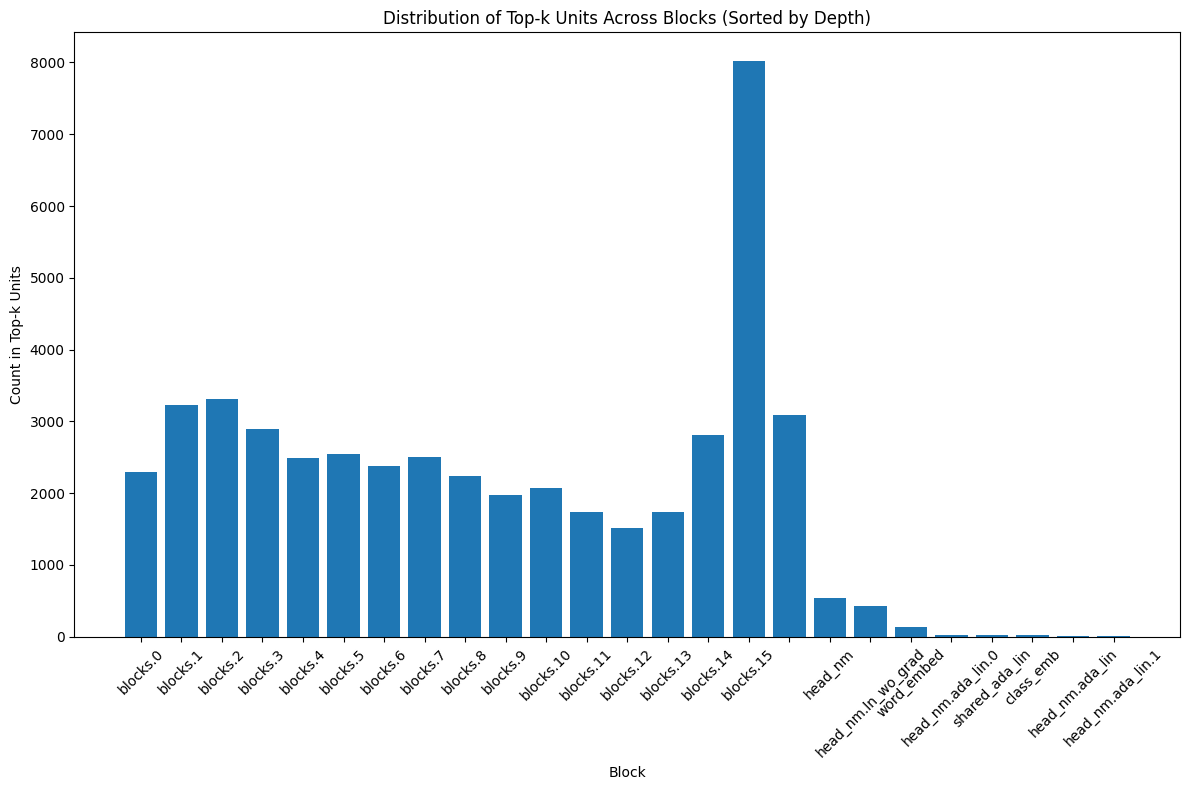

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each block in the topk_block_names list
block_counts = pd.Series(topk_block_names).value_counts().reset_index()
block_counts.columns = ['Block', 'Count']

# Extract block number for sorting
def block_sort_key(block_name):
    if block_name.startswith('blocks.'):
        try:
            return int(block_name.split('.')[1])
        except Exception:
            return 999
    else:
        return 1000  # Non-blocks at the end

block_counts['sort_key'] = block_counts['Block'].apply(block_sort_key)
block_counts = block_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(12, 8))
plt.bar(block_counts['Block'], block_counts['Count'])
plt.xlabel('Block')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Blocks (Sorted by Depth)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

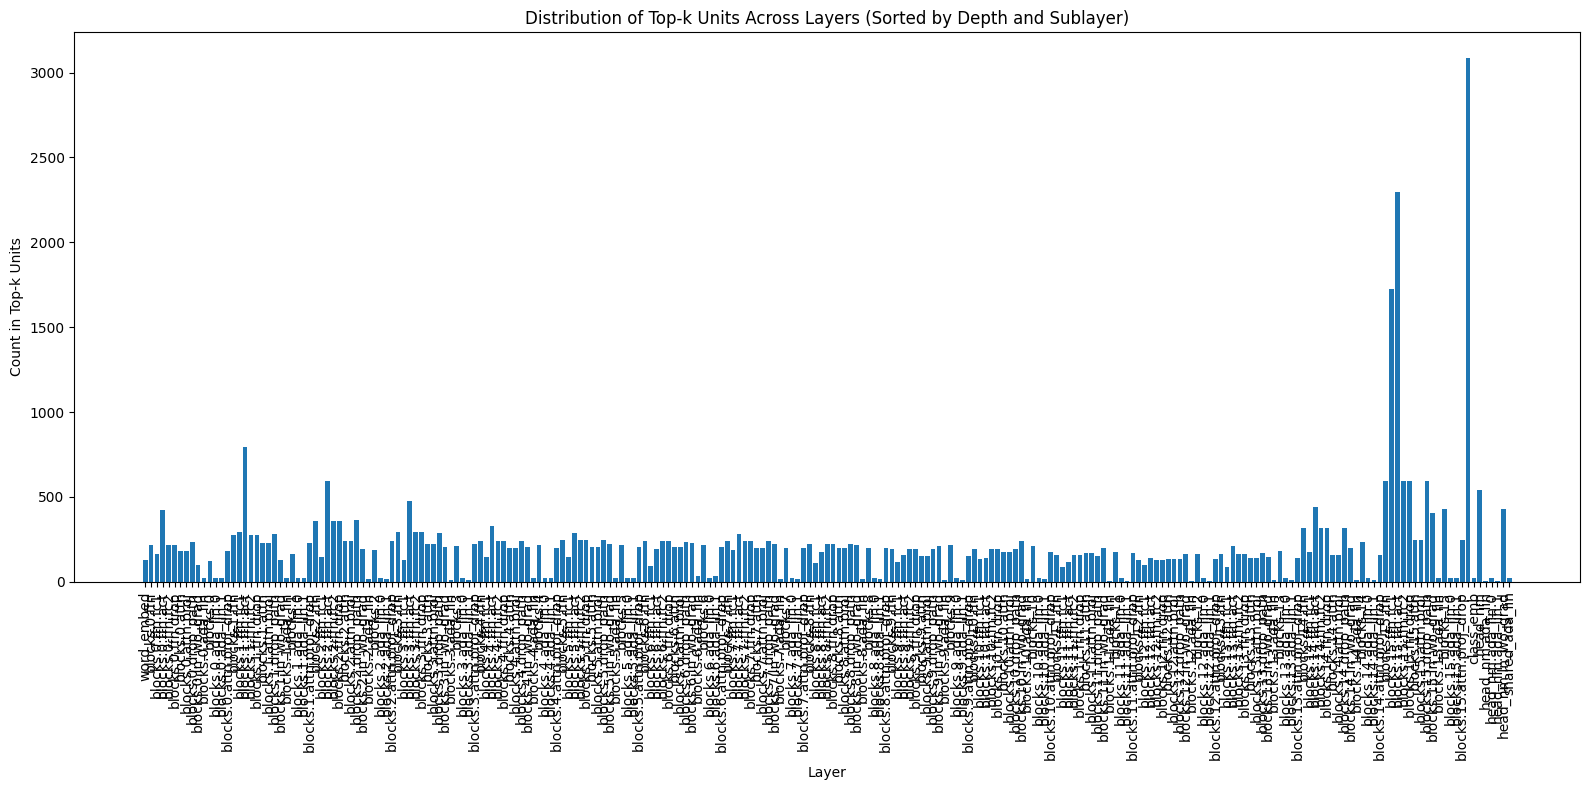

In [43]:
import pandas as pd

import matplotlib.pyplot as plt

# Count occurrences of each layer in the topk_layer_names list
layer_counts = pd.Series(topk_layer_names).value_counts().reset_index()
layer_counts.columns = ['Layer', 'Count']

# Extract block and sublayer number for sorting
def layer_sort_key(layer_name):
    if layer_name.startswith('blocks.'):
        parts = layer_name.split('.')
        try:
            block_num = int(parts[1])
        except Exception:
            block_num = 999
        # Try to sort sublayers: ffn, attn, drop_path, etc.
        sublayer_priority = {
            'ffn': 0, 'ffn.fc1': 1, 'ffn.act': 2, 'ffn.fc2': 3, 'ffn.drop': 4,
            'attn': 10, 'attn.proj': 11, 'drop_path': 20, 'ln_wo_grad': 30, 'ada_lin': 40
        }
        sublayer = '.'.join(parts[2:]) if len(parts) > 2 else ''
        sublayer_idx = sublayer_priority.get(sublayer, 99)
        return (block_num, sublayer_idx, layer_name)
    elif layer_name == 'word_embed':
        return (-2, 0, layer_name)
    elif layer_name == 'head':
        return (999, 0, layer_name)
    else:
        return (998, 0, layer_name)

layer_counts['sort_key'] = layer_counts['Layer'].apply(layer_sort_key)
layer_counts = layer_counts.sort_values('sort_key').reset_index(drop=True)

# Plot bar chart
plt.figure(figsize=(16, 8))
plt.bar(layer_counts['Layer'], layer_counts['Count'])
plt.xlabel('Layer')
plt.ylabel('Count in Top-k Units')
plt.title('Distribution of Top-k Units Across Layers (Sorted by Depth and Sublayer)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()